# Evaluation

This notebook evaluates the performance of hardware logic functions that were automatically generated using Syntax-Guided Synthesis (SyGuS). We compare the output of the synthesized SMT-LIB code against a ground-truth hardware model ran on randomly generated test cases. To generate the results, simply run the entire notebook.

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import subprocess
import os
import sys
import math


project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)

from src.synthesis_targets.multiplication import MultiplicationTarget, to_smt_bitvec
from src.synthesis_driver import SynthesisConfig


RESULTS_DIR = "../results/"
SOLUTION_MANT_FILE = os.path.join(RESULTS_DIR, "solution_multiplication_mant.smt2")
SOLUTION_EXP_FILE = os.path.join(RESULTS_DIR, "solution_multiplication_exp.smt2")

MANT_FUNCTION_NAME = "mult_mxint_mant"
EXP_FUNCTION_NAME = "mult_mxint_exp"

NUM_TEST_CASES = 100
FLOAT_RANGE_MIN = -math.sqrt(112)
FLOAT_RANGE_MAX = math.sqrt(112)

SMT_EVAL_FILE = "temp_eval.sl"

In [30]:
def bit_string_to_int(bv_string: str) -> int:
    if not bv_string or not bv_string.startswith('#b'):
        raise ValueError("Invalid bit-vector string format")
    binary_part = bv_string[2:]
    unsigned_value = int(binary_part, 2)
    if len(binary_part) > 1 and binary_part[0] == '1':
        return unsigned_value - (1 << len(binary_part))
    return unsigned_value

def gen_eval_script(solution_filepath: str, function_call_str: str, output_filepath: str):
    try:
        with open(solution_filepath, 'r') as f:
            solution_content = f.read().strip()
    except FileNotFoundError:
        print(f"ERROR: Solution file not found at '{solution_filepath}'")
        raise
        
    if solution_content.startswith('(') and solution_content.endswith(')'):
        match = re.match(r'\s*\((.*)\)\s*$', solution_content, re.DOTALL)
        if match:
            solution_content = match.group(1).strip()
    
    match = re.search(r'\(_\s+BitVec\s+(\d+)\)', solution_content)
    if not match:
        raise ValueError(f"Could not parse return type from solution file: {solution_filepath}")
    return_type = f"(_ BitVec {match.group(1)})"

    output_content = f"""(set-logic BV)
{solution_content}
(synth-fun output () {return_type})
(constraint (= output {function_call_str}))
(check-synth)
"""
    with open(output_filepath, 'w') as f:
        f.write(output_content)

def run_and_parse_cvc5(smt_filepath: str) -> str | None:
    try:
        result = subprocess.run(
            ["cvc5", smt_filepath], capture_output=True, text=True, check=True, timeout=5
        )
        output_str = result.stdout.strip()
        parts = output_str.replace('(', ' ').replace(')', ' ').split()
        if not parts:
            print("ERROR: CVC5 produced empty output.")
            return None
        value = parts[-1]
        if value.startswith("#b"):
            return value
        else:
            print(f"ERROR: CVC5 output did not contain a bit-vector value. Full output:\n{output_str}")
            return None
    except FileNotFoundError:
        print("ERROR: 'cvc5' command not found. Ensure it is in your system's PATH.")
        raise
    except subprocess.CalledProcessError as e:
        print(f"ERROR: CVC5 failed. Stderr:\n{e.stderr.strip()}")
        return None
    finally:
        if os.path.exists(smt_filepath):
            os.remove(smt_filepath)

def evaluate_smt_function(solution_filepath: str, function_call_str: str) -> int | None:
    try:
        gen_eval_script(solution_filepath, function_call_str, SMT_EVAL_FILE)
        result_bv = run_and_parse_cvc5(SMT_EVAL_FILE)
        if result_bv:
            return bit_string_to_int(result_bv)
    except Exception as e:
        print(f"An error occurred during evaluation: {e}")
    return None


def analyze_and_plot_errors(errors: np.ndarray, title: str, color: str, xlim_max: int = None, log_scale_y: bool = False):

    mean_error = np.mean(errors)
    median_error = np.median(errors)
    max_error = np.max(errors)
    num_exact = np.sum(errors == 0)
    total = len(errors)
    percent_exact = (num_exact / total) * 100

    print(f"--- {title} Performance ---")
    print(f"Total Test Cases:      {total}")
    print(f"Exact Matches:         {percent_exact:.2f}%")
    print(f"Mean Absolute Error:   {mean_error:.4f}")
    print(f"Median Absolute Error: {median_error:.4f}")
    print(f"Max Absolute Error:    {max_error}")

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(10, 6))
    
    plot_title = f"Distribution of Absolute {title} Errors"
    display_max = int(max_error)
    

    bins = np.arange(display_max + 2) - 0.5
    ax.hist(errors, bins=bins, color=color, edgecolor='black', rwidth=0.8)
    

    ax.axvline(mean_error, color='red', linestyle='--', label=f'Mean Error: {mean_error:.4f}')
    ax.axvline(median_error, color='orange', linestyle='--', label=f'Median Error: {median_error:.4f}')
    
    ax.set_title(plot_title)
    ax.set_xlabel(f"Absolute Error in {title}")
    ax.set_ylabel("Frequency (Number of Cases)")
    ax.set_xticks(np.arange(display_max + 1))
    ax.legend()
    plt.tight_layout()
    plt.show()

In [31]:


      
test_data = []
target = MultiplicationTarget()
config = SynthesisConfig()

for _ in range(NUM_TEST_CASES):
    f1 = random.uniform(FLOAT_RANGE_MIN, FLOAT_RANGE_MAX)
    f2 = random.uniform(FLOAT_RANGE_MIN, FLOAT_RANGE_MAX)
    print(f1)
    print(f2)
    
    gt = target.calculate_ground_truth(f1, f2, config)
    print(gt)
    if gt is not None:
        test_data.append(gt)


    

-8.514402755023514
-0.46615245112209713
{'m1': -5, 'e1': 4, 'm2': -8, 'e2': -1, 'final_mant': 5, 'final_exp': 3, 'renorm_flag': 0}
-6.8235920839497375
-10.302219736452953
{'m1': -7, 'e1': 3, 'm2': -6, 'e2': 4, 'final_mant': 5, 'final_exp': 7, 'renorm_flag': 0}
8.657090007308401
-8.908116494637998
{'m1': 4, 'e1': 4, 'm2': -5, 'e2': 4, 'final_mant': -5, 'final_exp': 7, 'renorm_flag': 1}
-6.459870200916737
2.2715042363022597
{'m1': -7, 'e1': 3, 'm2': 4, 'e2': 2, 'final_mant': -7, 'final_exp': 4, 'renorm_flag': 1}
-5.261411909625895
8.63022533268316
{'m1': -6, 'e1': 3, 'm2': 4, 'e2': 4, 'final_mant': -6, 'final_exp': 6, 'renorm_flag': 1}
4.769388692915069
-7.1248968677433115
{'m1': 4, 'e1': 3, 'm2': -8, 'e2': 3, 'final_mant': -4, 'final_exp': 6, 'renorm_flag': 1}
4.447136024019144
8.18739858632722
{'m1': 4, 'e1': 3, 'm2': 4, 'e2': 4, 'final_mant': 4, 'final_exp': 6, 'renorm_flag': 1}
4.620964823058463
-4.174414375226353
{'m1': 4, 'e1': 3, 'm2': -5, 'e2': 3, 'final_mant': -5, 'final_exp': 5

In [32]:
print("--- Starting Eval ---")
gt_mantissas = []
synth_mantissas = []
gt_exponents = []
synth_exponents = []
evaluation_successful = True

for i, gt in enumerate(test_data):
    if (i+1) % 50 == 0 or (i+1) == len(test_data):
        print(f"Evaluated {i+1}/{len(test_data)} test cases.")
    
    m1_bv = to_smt_bitvec(gt['m1'], config.MANTISSA_WIDTH)
    m2_bv = to_smt_bitvec(gt['m2'], config.MANTISSA_WIDTH)
    mant_call_str = f"({MANT_FUNCTION_NAME} {m1_bv} {m2_bv})"
    synth_mant = evaluate_smt_function(SOLUTION_MANT_FILE, mant_call_str)
    

    e1_bv = to_smt_bitvec(gt['e1'], config.EXPONENT_WIDTH)
    e2_bv = to_smt_bitvec(gt['e2'], config.EXPONENT_WIDTH)
    flag_bv = to_smt_bitvec(gt['renorm_flag'], 1)
    exp_call_str = f"({EXP_FUNCTION_NAME} {e1_bv} {e2_bv} {flag_bv})"
    synth_exp = evaluate_smt_function(SOLUTION_EXP_FILE, exp_call_str)
    
    if synth_mant is None or synth_exp is None:
        print(f"Error on test case {i+1}.")
        evaluation_successful = False
        break
    gt_mantissas.append(gt['final_mant'])
    synth_mantissas.append(synth_mant)
    gt_exponents.append(gt['final_exp'])
    synth_exponents.append(synth_exp)

--- Starting Eval ---
Evaluated 50/100 test cases.
Evaluated 100/100 test cases.


--- Mantissa Performance ---
Total Test Cases:      100
Exact Matches:         92.00%
Mean Absolute Error:   0.4800
Median Absolute Error: 0.0000
Max Absolute Error:    12


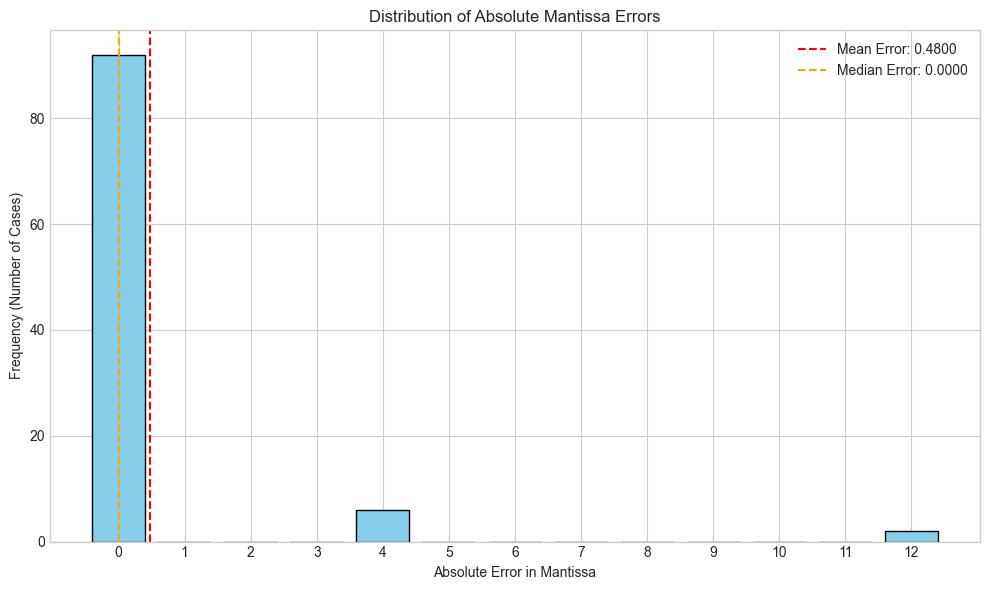

--- Exponent Performance ---
Total Test Cases:      100
Exact Matches:         92.00%
Mean Absolute Error:   0.0800
Median Absolute Error: 0.0000
Max Absolute Error:    1


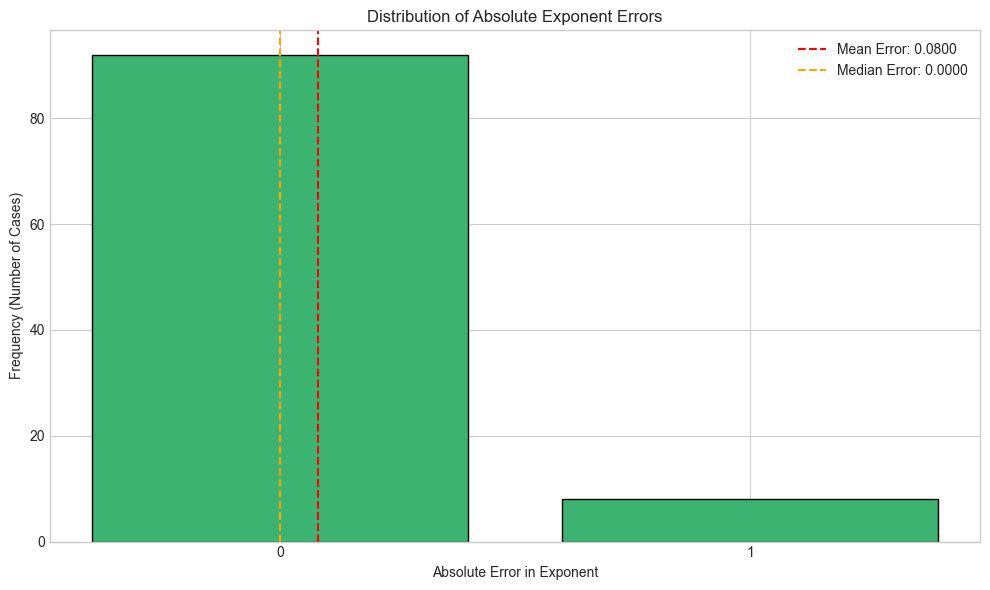

[  5.     80.    -80.    -14.    -48.    -32.     32.    -20.     96.
  40.    -80.    -10.     -0.875 -28.      3.5    24.     56.     28.
  64.    -40.    -96.     20.     16.     40.    -80.    -48.     14.
  16.      8.    -80.    -20.      8.    -28.    -64.     14.     40.
  24.      8.     40.    -32.    -48.     -8.      2.5    64.    -20.
  -1.75  -80.     28.    -40.    -40.     40.     56.     64.     10.
 -80.    -56.     24.    -56.     -6.      4.     32.     -6.    -32.
 -16.     10.    -10.    -20.      1.5     8.     96.     32.     24.
  -5.      1.5    48.      3.     64.    -80.    -40.     56.      0.625
  48.     80.     14.    -32.    -14.     -1.5    -2.5    -5.    -32.
  40.     -8.     48.    -12.    -14.    -56.     20.     -2.     16.
 -56.   ]
[  5.     80.    -80.    -14.    -48.    -32.     32.    -20.     96.
  40.    -80.    -10.     -0.875 -28.      3.5    24.     56.     28.
  64.    -40.    -96.     20.     16.     40.    -80.    -48.     14.
 -16.  

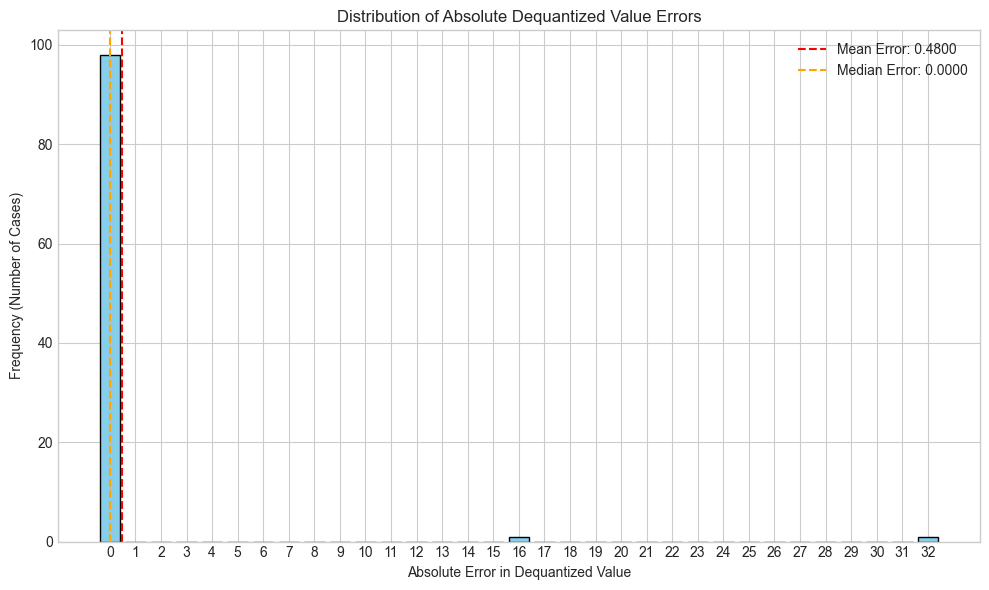

In [ ]:
def dequantize_mx(mantissa: int, exponent: int, width: int) -> float:
    scaling_factor = 2.0 ** (width - 1)
    return (mantissa / scaling_factor) * (2.0 ** exponent)

if evaluation_successful:

    mant_errors = np.abs(np.array(gt_mantissas) - np.array(synth_mantissas))
    analyze_and_plot_errors(mant_errors, "Mantissa", "skyblue")
    
    exp_errors = np.abs(np.array(gt_exponents) - np.array(synth_exponents))
    analyze_and_plot_errors(exp_errors, "Exponent", "mediumseagreen")
    
    gt_dequantized = np.array([dequantize_mx(gt_mantissas[i], gt_exponents[i], config.MANTISSA_WIDTH) for i in range(len(test_data))])
    synth_dequantized = np.array([dequantize_mx(synth_mantissas[i], synth_exponents[i], config.MANTISSA_WIDTH) for i in range(len(test_data))])
    dequant_errors = np.abs(gt_dequantized - synth_dequantized)
    analyze_and_plot_errors(dequant_errors, "Dequantized Value", "skyblue")
else:
    print("\nEvaluation did not complete successfully.")